# Rapport du projet annuel

## Auteur
- BENDAVID Natane
- TARDY Louis
- WADE Cheikh Abdourahmane

## Problématique 

Problématiques applicatives : Classification d'images de vêtement, 3 Types :
- Chaussures
- Haut
- Pantalons

## Descriptif du rapport
Le but de ce rapport est de présenter l’étude des performances de tous les algorithmes et modèles implementés lors de ce projet. 

Nous metterons en évidence l'impact des différents paramètres des algorithmes étudiés sur la rapidité de convergence de ceux-ci.

Dans ce rapport nous mettront en évidence 4 algorithmes de machine learning :

- Modèle linéaire
- Perceptron Multi Couches
- Radial Basis Function Network
- SVM 

L’ensemble de ces modèles et algorithmes sont implémentés en rust (convertie en lib C) de manière à pouvoir être
aisément utilisé comme une bibliothèque dynamique manipulée depuis des scripts python

Nous étudierons plusieurs cas de test par algorithme implémenté pour démontrer sont n'efficacité ou non selon le problème

Nous étudierons des cas de classifications et de régressions

## Import de la lib

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from ctypes import *
import os as os
from PIL import Image
from os import listdir
from os.path import isfile, join

In [2]:
print(os.getcwd())

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport


In [3]:
debug = True
if debug:
    my_dll_path = os.getcwd() + "/../../Lib/debug/machine_learning_c.dll"
else:
    my_dll_path = os.getcwd() + "/../../Lib/release/machine_learning_c.dll"
my_lib = CDLL(my_dll_path)

## Modèle linéaire

Pour implémenter l'algorithme de modelé linéaire nous avons suivie un workflow spécifique pour préparer, entraîner et exploiter les données en sortie :

1) Crétion d'un modèle :
- Création d'un modèle aléatoire de base, avec des valeurs comprises entre -1 et 1 

2) Entrainement du modèle:
- Pour la classification : Entrainement du modèle avec la règle de Rosenblatt
- Pour la régression : Entrainement du modèle avec la pseudo inverse

3) Prédiction des résultats

4) Test du modèle

### Paramétrage de la lib

In [4]:
# Création d'un model
my_lib.create_linear_model.restype = c_void_p
my_lib.create_linear_model.argtypes = [c_int]
# Prédiction d'un model pour la classification
my_lib.predict_linear_classification.argtypes = [
    c_void_p,
    POINTER(c_double),
    c_int
]
my_lib.predict_linear_classification.restype = c_double
# Prédiction d'un model pour la régression
my_lib.predict_linear_regression.argtypes = [
    c_void_p,
    POINTER(c_double),
    c_int
]
my_lib.predict_linear_regression.restype = c_double
# Entrainement du model pour la classification
my_lib.train_linear_model_classification_python.argtypes = [
    c_void_p,
    POINTER(c_double),
    POINTER(c_double),
    c_int,
    c_int,
    c_int,
    c_double
]
my_lib.train_linear_model_classification_python.restype = None
# Entrainement du model pour la regression
my_lib.train_linear_model_regression_python.argtypes = [
    c_void_p,
    POINTER(c_double),
    POINTER(c_double),
    c_int,
    c_int
]
my_lib.train_linear_model_regression_python.restype = None
# Creation du modele PMC
my_lib.create_mlp.argtypes = [
    POINTER(c_int64),
    c_int
]
my_lib.create_mlp.restype = c_void_p
# Prediction classification
my_lib.mlp_classification.argtypes = [c_void_p, POINTER(c_double), c_int]
my_lib.mlp_classification.restype = c_void_p
my_lib.mlp_classification_image.argtypes = [c_void_p, POINTER(c_double), c_int]
my_lib.mlp_classification_image.restype = c_int
my_lib.mlp_classification_max_value.argtypes = [c_void_p, POINTER(c_double), c_int]
my_lib.mlp_classification_max_value.restype = c_double

my_lib.mlp_regression.argtypes = [c_void_p, POINTER(c_double), c_int]
my_lib.mlp_regression.restype = c_void_p
my_lib.mlp_regression_max_value.argtypes = [c_void_p, POINTER(c_double), c_int]
my_lib.mlp_regression_max_value.restype = c_double
# Entrainement du PMC
my_lib.mlp_train_classification.argtypes = [c_void_p,
                                            c_int,
                                            POINTER(c_double),
                                            c_int,
                                            POINTER(c_double),
                                            c_int,
                                            c_int,
                                            c_double]
my_lib.mlp_train_classification.restype = None
my_lib.mlp_train_regression.argtypes = [c_void_p,
                                            c_int,
                                            POINTER(c_double),
                                            c_int,
                                            POINTER(c_double),
                                            c_int,
                                            c_int,
                                            c_double]
my_lib.mlp_train_regression.restype = None

# Sérialisation / Deserialisation
my_lib.deserialized_lineare_model.restype = c_void_p
my_lib.serialized_lineare_modele.argtypes = [
    c_void_p,
    c_int
]
my_lib.serialized_lineare_modele.restype = None

my_lib.serialized_mlp.argtypes = [
    c_void_p
]
my_lib.serialized_mlp.restype = None
my_lib.deserialized_mlp.restype = c_void_p

## Classification modele lineaire

### Cas d'un test simple
Nous commençons à tester notre modèle sur un cas de test assez simple. 

Le but est de séparer deux points pour pouvoir les classer.

After Training
1.0
-1.0
-1.0


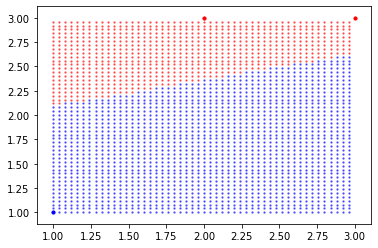

<Figure size 432x288 with 0 Axes>

In [5]:
# Data
X = np.array([
      [1, 1],
      [2, 3],
      [3, 3]
], dtype='float64')
Y = np.array([
      1,
      -1,
      -1
], dtype='float64')
flattened_X = X.flatten()
#Création du model
model = my_lib.create_linear_model(c_int(X.shape[1]))

#Entrainement du model
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    Y.ctypes.data_as(POINTER(c_double)),
    X.shape[0],
    X.shape[1],
    1000,
    0.01
)

#Prediction du model
print("After Training")
for inputs_k in X:
    print(my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k)))


#Test du model
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0 + 1.0

test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    predicted_value = my_lib.predict_linear_classification(
                model,
                test_input_k.ctypes.data_as(POINTER(c_double)),
                len(test_input_k))
    if predicted_value == 1.0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X[0, 0], X[0, 1], color='blue', s=10)
plt.scatter(X[1:3, 0], X[1:3, 1], color='red', s=10)
plt.show()
plt.clf()

##### Exploitation des resultats

Grace à l'implémentation de la règle de ressemblante et au bon paramétrage du modèle (1000 tours de boucle est une epoch à 0.01) nous remarquons une bonne séparation entre le point bleu et les deux points rouge.

### Cas d'un test multi lineaire (Sur-entrainement)
Nous testons notre modèle sur un cas de test multi linéaire. 

Le but est de séparer les points bleus et les points rouges pour pouvoir les classer.

Test model Training


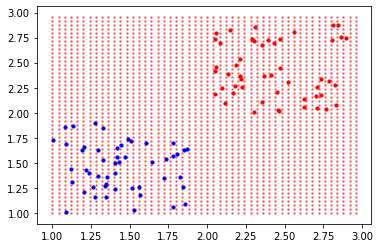

<Figure size 432x288 with 0 Axes>

In [6]:
X = np.concatenate([
    np.random.random((50,2)) * 0.9 + np.array([1, 1]),
    np.random.random((50,2)) * 0.9 + np.array([2, 2])],
    axis = 0)
Y = np.concatenate([np.ones((50, 2)), np.ones((50, 2)) * -1.0])
flattened_X = X.flatten()
#Création du model
model = my_lib.create_linear_model(c_int(X.shape[1]))

#Entrainement du model
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    Y.ctypes.data_as(POINTER(c_double)),
    X.shape[0],
    X.shape[1],
    10000,
    0.00000001
)

#Test du model
print("Test model Training")
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0 + 1.0

test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    predicted_value = my_lib.predict_linear_classification(
                model,
                test_input_k.ctypes.data_as(POINTER(c_double)),
                len(test_input_k))
    if predicted_value == 1.0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)

plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', s=10)
plt.scatter(X[50:100,0], X[50:100,1], color='red', s=10)
plt.show()
plt.clf()

##### Exploitation des resultats

Nous pouvons remarquer ici qu'avec un mauvais paramétrage de l'entraînement, 10 millions de tours de boucle et une epoch de  0.0000001, nous avons un sur-entraînement du modèle. Nous constatons alors que nos résultats sont faussés dû au sur-entraînement du modèle.

### Cas d'un test simple (sous-entrainement)
Nous testons notre modèle sur un cas de test simple pour montrer le sou-entrainement du modèle dû à son mauvais paramétrage. 

Le but est de séparer les points bleus et les points rouges pour pouvoir les classer.

Nous avons repris ici le premier cas de test simpl:

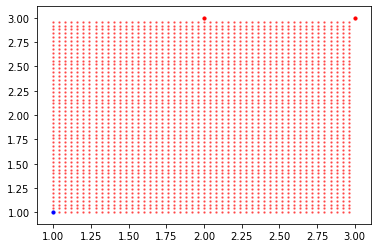

##### Exploitation des resultats

Nous pouvons remarquer ici qu'avec un mauvais paramétrage de l'entraînement, 1 tour de boucle et une epoch de 0.01, nous avons un sous-entraînement du modèle. 
Nous constatons alors que nos résultats sont faussés dû au sous-entraînement du modèle.

### Conclusion classification modèle lineaire

Avec les différents tests que nous avons mis au point au-dessus, nous pouvons constater que le paramétrage du modèle joue un rôle crucial sur l'entraînement de celui-ci. 

En utilisant de grande valeur de paramétrage nous constatons un sur-entraînement du modèle, mais au contraire en utilisant de très petite valeur nous constatons un sous-entraînement du modèle. 

Le but est alors de trouver le bon paramétrage pour exploité au mieux l'entraînement. 

## Régression modele lineaire

### Cas d'un test Linear Simple 2D
Nous commençons à tester notre modèle sur un cas de test simple. 

Le but est de pouvoir tracé une droite qui passe par les deux points.

After Training
[2.0, 3.0]


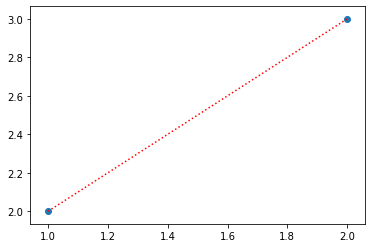

<Figure size 432x288 with 0 Axes>

In [10]:
X = np.array([
      [1],
      [2]
], dtype='float64')
Y = np.array([
      2,
      3
], dtype='float64')
flattened_X = X.flatten()

#Création du model
model = my_lib.create_linear_model(c_int(X.shape[1]))

#Entrainement du model
my_lib.train_linear_model_regression_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    Y.ctypes.data_as(POINTER(c_double)),
    X.shape[0],
    X.shape[1]
)

#Prediction du model
result = []
print("After Training")
for inputs_k in X:
    result.append(my_lib.predict_linear_regression(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k)))
print(result)

plt.scatter(X,Y)
x = np.linspace(-10,10)
y = result[0]*x + result[1]
plt.plot(X, result, ':r')
plt.show()
plt.clf()

##### Exploitation des resultats

En utilisant notre entrainement de régression, avec le calcul de la pseudo inverse pour calculer W, nous pouvons déterminer les valeur de l'expression d'une droite affine. Une fois notre modèle entrainé,nous testons les valeurs sur un intervalles de (-10, 10). 

Apres la création de la droite affine Y = aX + b, on trace la droite sur la courbe.

Pour cette entrainement, il n'y pas de hyper-parametre à specifier (ni les tours de boucle, ni le pas d'apprentissage) car le calcul de la pseudo inverse donne directement les valeurs attendues.

Concernant les resultats, nous obtenous le resultat attendu.
Nous pouvons conclure que cette algorithme d'entrainement pour la régression est opérationnelle pour ce test

## Classification MLP

### Principe

Pour l'implémentation du MLP nous utilisons la fonction d'activation sigmoide **TanH**

Lors de la création de notre réseau de neurones nous avons plusieur parametre en jeux: 

- W : le poids de la couche liant le neurone de la couche à son précedent.
- X : la valeur de sortie effective d'un neurone
- Deltas

### Rétropropagation du gradient

Pour utilisé notre entrainement MLP nous avons implémenté la rétropropagation du gradient.
Pour la classification nous utilisons la fonction d'activation TanH

### Cas d'un test (XOR)
Pour montrer l'efficacité du MLP, nous allons tester le cas du XOR (ou exclusif)qui est imposiible à réaliser pour le modelé lineaire.

Le but est de classifier les points rouge et bleu qui sont placé à leur opposé.

In [11]:
# Le dataset
X = np.array([[1, 0], [0, 1], [0, 0], [1, 1]], dtype='float64')
Y = np.array([1, 1, -1, -1,], dtype='float64')

flattened_X = X.flatten()
flattened_Y = Y.flatten()

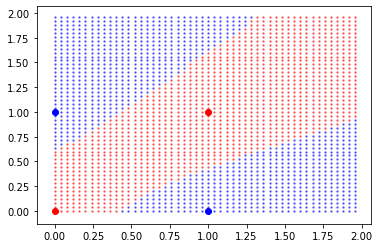

<Figure size 432x288 with 0 Axes>

In [12]:
# Création d'un réseau de neurones à une couche cachée avec 10 neurones sur la couche cachée
npl = list([2, 3, 1])
npl_pointer = (c_int64 * 3)(*npl)
mlp = my_lib.create_mlp(npl_pointer, len(npl))
x_train_pointer = (c_double * len(flattened_X))(*flattened_X)
y_train_pointer = (c_double * len(flattened_Y))(*flattened_Y)

# Entrainement du modele
my_lib.mlp_train_classification(mlp, len(X), x_train_pointer, len(flattened_X), y_train_pointer,
                                    len(flattened_Y), 10000, 0.01)
for i in range(len(X)):
    x_pointer = (c_double * len(X[i]))(*X[i])
    my_lib.mlp_classification(mlp, x_pointer, len(X[i]))
    predict = my_lib.mlp_classification_image(mlp, x_pointer, len(X[i]))
    max_value = my_lib.mlp_classification_max_value(mlp, x_pointer, len(X[i]))
    
#Test du model
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0
test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    x_pointer = (c_double * len(test_points[k]))(*test_points[k])
    predict = my_lib.mlp_classification_max_value(mlp, x_pointer, len(test_points[k]))
    if predict > 0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X[0:2, 0], X[0:2, 1], color='blue')
plt.scatter(X[2:4,0], X[2:4,1], color='red')
plt.show()
plt.clf()

##### Exploitation des resultats

En utilisant notre entrainement MLP de classification, avec l'implémentation de la rétropropagation du gradient, nous pouvons déterminer via le shéma que les points sont correctement séparé en deux classes rouge et bleu d'un coté

Nous avons dans une premier étape créé un réseau de neurone d'une couche caché de 3 neurones. 

Nous avons ensuite paramétre notre entrainement avec une epoch de 10000 et un learning rate de 0.01

Nous pouvons conclure que cette algorithme d'entrainement pour la classification d'un cas de test XOR est opérationnelle.

### Cas d'un test multi lineaire avec le MLP overfitting (Sur-entrainement) 
Nous testons notre modèle sur un cas de test multi linéaire. 

Le but est de séparer les points bleus et les points rouges pour pouvoir les classer.

Nous allons montrer ici un cas de sur-entrainement.

In [13]:
X = np.concatenate([
    np.random.random((50,2)) * 0.9 + np.array([1, 1]),
    np.random.random((50,2)) * 0.9 + np.array([2, 2])],
    axis = 0)
Y = np.concatenate([np.ones((50, 2)), np.ones((50, 2)) * -1.0])
flattened_X = X.flatten()
flattened_Y = Y.flatten()

Test model Training


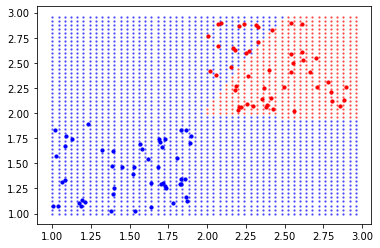

<Figure size 432x288 with 0 Axes>

In [15]:
npl = list([2, 10, 2])
npl_pointer = (c_int64 * 3)(*npl)
mlp = my_lib.create_mlp(npl_pointer, len(npl))
x_train_pointer = (c_double * len(flattened_X))(*flattened_X)
y_train_pointer = (c_double * len(flattened_Y))(*flattened_Y)
# Entrainement du modele
my_lib.mlp_train_classification(mlp, len(X), x_train_pointer, len(flattened_X), y_train_pointer,
                                    len(flattened_Y), 10000, 0.000001)
for i in range(len(X)):
    x_pointer = (c_double * len(X[i]))(*X[i])
    predict = my_lib.mlp_classification_image(mlp, x_pointer, len(X[i]))
#     print(predict)

#Test du model
print("Test model Training")
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0 + 1.0

test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    x_pointer = (c_double * len(test_points[k]))(*test_points[k])
    predict = my_lib.mlp_classification_max_value(mlp, x_pointer, len(test_points[k]))
    if predict > 0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', s=10)
plt.scatter(X[50:100,0], X[50:100,1], color='red', s=10)
plt.show()
plt.clf()

##### Exploitation des resultats

Nous pouvons remarquer ici qu'avec un mauvais paramétrage de l'entraînement entraine une analyse statistique qui correspond trop précisément à une collection particulière d'un ensemble données. Nous constatons alors que nos résultats sont faussés dû au sur-entraînement du modèle.

Pour remedier au problemes il y a un plusieur moyen:

- Ne pas entrainé notre model trop longtemps
- Avoir un pas d'apprentisage proportionnelle au nombre d'epoque
- Augmenter le dataset d'entrainement

### Cas d'un test multi lineaire avec le MLP underfitting  (sous-entrainement) 
Nous testons notre modèle sur un cas de test multi linéaire. 

Le but est de séparer les points bleus et les points rouges pour pouvoir les classer.

Nous allons montrer ici un cas de sous-entrainement.

In [16]:
X = np.concatenate([
    np.random.random((50,2)) * 0.9 + np.array([1, 1]),
    np.random.random((50,2)) * 0.9 + np.array([2, 2])],
    axis = 0)
Y = np.concatenate([np.ones((50, 2)), np.ones((50, 2)) * -1.0])
flattened_X = X.flatten()
flattened_Y = Y.flatten()

Test model Training


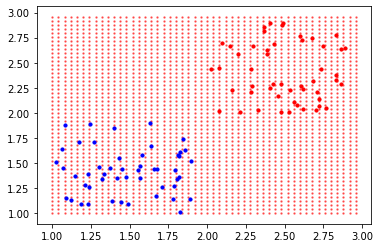

<Figure size 432x288 with 0 Axes>

In [17]:
npl = list([2, 10, 2])
npl_pointer = (c_int64 * 3)(*npl)
mlp = my_lib.create_mlp(npl_pointer, len(npl))
x_train_pointer = (c_double * len(flattened_X))(*flattened_X)
y_train_pointer = (c_double * len(flattened_Y))(*flattened_Y)
# Entrainement du modele
my_lib.mlp_train_classification(mlp, len(X), x_train_pointer, len(flattened_X), y_train_pointer,
                                    len(flattened_Y), 10, 0.1)
for i in range(len(X)):
    x_pointer = (c_double * len(X[i]))(*X[i])
    predict = my_lib.mlp_classification_image(mlp, x_pointer, len(X[i]))
#     print(predict)

#Test du model
print("Test model Training")
test_points = np.array([[i, j] for i in range(50) for j in range(50)], dtype='float64') / 50.0 * 2.0 + 1.0

test_points_predicted = np.zeros(len(test_points))
red_points = []
blue_points = []
for k, test_input_k in enumerate(test_points):
    x_pointer = (c_double * len(test_points[k]))(*test_points[k])
    predict = my_lib.mlp_classification_max_value(mlp, x_pointer, len(test_points[k]))
    if predict > 0:
        blue_points.append(test_input_k)
    else:
        red_points.append(test_input_k)

red_points = np.array(red_points)
blue_points = np.array(blue_points)

if len(red_points) > 0:
    plt.scatter(red_points[:, 0], red_points[:, 1], color='red', alpha=0.5, s=2)
if len(blue_points) > 0:
    plt.scatter(blue_points[:, 0], blue_points[:, 1], color='blue', alpha=0.5, s=2)
plt.scatter(X[0:50, 0], X[0:50, 1], color='blue', s=10)
plt.scatter(X[50:100,0], X[50:100,1], color='red', s=10)
plt.show()
plt.clf()

##### Exploitation des resultats

Nous pouvons remarquer ici qu'avec un mauvais paramétrage de l'entraînement le modèle n’arrive même pas à capturer les corrélations du Training Set.
Par conséquent, le coût d’erreur en phase d’apprentissage reste grand.
Nous constatons alors que nos résultats sont faussés dû au sur-entraînement du modèle.


### Probleme d'overfitting / underfitting
Pour remedier au problemes d'un overfitting il y a un plusieur moyen:

- Ne pas entrainé notre model trop longtemps
- Avoir un pas d'apprentisage proportionnelle au nombre d'epoch
- Augmenter le dataset d'entrainement

Pour remedier au problemes d'un underfitting, cela correspond à l'inverse des recomandation du overfitting:

- Entrainé notre model un peu plus longtemps
- Augmenter le pas d'apprentisage, proportionnelle au nombre d'epoch

Pour terminer pour avoir un modéle bien entraine il faut trouvé le juste mileu entre l'overfitting et l'underfitting.

# Entrainement des modeles sur le dataset d'image

## Fonctions pour charger le dataset d'image

Nous chargeons grâce à ces fonctions nos images dans un tableau numpy sous un format 30x30 et RGB (3)

Nous avons à la fin un tableau avec une ligne par image. Une image correspond à 2700 valeurs. (30x30x3)

La fonction pour charger les images prend en parametre :
- Le chemin vers le dossier des images
- Le label lié à la classe de l'image
- Le nombre max d'image utilisé

In [18]:
def load_image_dataset(path, label, nb_img_max):
    fichiers = [f for f in listdir(path) if isfile(join(path, f))]
    img = []
    y = []
    nb_img = 0
    for i in fichiers:
        im = Image.open(path + (i))
        im_arr1 = np.array(im) / 255
        if im.width is 30 and im.height is 30 and len(im_arr1.shape) is 3:
            print(path + (i))
            im_arr1 = np.reshape(im_arr1, (30 * 30 * 3))
            img.append(im_arr1)
            y.append(label)
            nb_img += 1
            if nb_img >= nb_img_max:
                break
    # y = np.reshape(y, 3 * len(y))
    return np.array(img), y

In [19]:
def load_one_image_dataset(path):
    img = []
    im = Image.open(path)
    im_arr1 = np.array(im) / 255
    if im.width is 30 and im.height is 30 and len(im_arr1.shape) is 3:
        print(path)
        im_arr1 = np.reshape(im_arr1, (30 * 30 * 3))
        img.append(im_arr1)
    return np.array(img)

#### Images d'entrainement

In [20]:
# path_bas_train = os.getcwd() + "/../../Dataset/Raw/Bas/image_scrap/image_resize/"
# path_chaussure_train = os.getcwd() + "/../../Dataset/Raw/Chaussure/image_scrap/image_resize/"
# path_haut_train = os.getcwd() + "/../../Dataset/Raw/Haut/image_scrap/image_resize/"

path_bas_train = os.getcwd() + "/../../Dataset/Train/Bas/"
path_chaussure_train = os.getcwd() + "/../../Dataset/Train/Chaussure/"
path_haut_train = os.getcwd() + "/../../Dataset/Train/Haut/"

#### Images de validation

In [21]:
path_bas_validation = os.getcwd() + "/../../Dataset/Validation/Bas/"
path_chaussure_validation = os.getcwd() + "/../../Dataset/Validation/Chaussure/"
path_haut_validation = os.getcwd() + "/../../Dataset/Validation/Haut/"

## Entrainement du dataset avec le MLP

Le but de cette partie est d'entraîné notre dataset grâce a l'algorithme du MLP implémenté dans notre librairie.

Pour cela, nous allons utiliser le dataset d'image que nous avons créé avec 3 classes différentes:
- Les bas
- Les chaussures
- Les hauts

### Chargement du dataset d'entraînement pour le MLP 

In [22]:
image_bas_train, y_bas_train = load_image_dataset(path_bas_train, [1.0, -1.0, -1.0], 100)
image_chaussure_train, y_chaussure_train = load_image_dataset(path_chaussure_train, [-1.0, 1.0, -1.0], 100)
image_haut_train, y_haut_train = load_image_dataset(path_haut_train, [-1.0, -1.0, 1.0], 100)

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (107).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (108).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (109).jpg
C:\Users\MOI\

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (107).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/h (108).jpg
C:\

On assemble toutes les images de chaque classe dans un même tableau.

In [23]:
x_train = np.concatenate((image_bas_train, image_chaussure_train, image_haut_train))
y_train = np.concatenate((y_bas_train, y_chaussure_train, y_haut_train))
print(len(x_train))

300


#### Création du réseau de neurones

Nous avons pris ici un réseau de neurones de 3 couches cachées de 20 neurones chacune.

In [24]:
npl = list([2700, 20, 20, 20, 3])
npl_pointer = (c_int64 * 5)(*npl)
mlp = my_lib.create_mlp(npl_pointer, len(npl))

#### Entrainement du model

Nous lançons l'entraînement du model avec un **pas d'apprentissage** de **0.001** avec **10 000 itérations**

In [25]:
flattened_X = x_train.flatten()
flattened_Y = y_train.flatten()
x_train_pointer = (c_double * len(flattened_X))(*flattened_X)
y_train_pointer = (c_double * len(flattened_Y))(*flattened_Y)
my_lib.mlp_train_classification(mlp, len(x_train), x_train_pointer, len(flattened_X), y_train_pointer,
                                len(flattened_Y), 10000, 0.001)

#### Sérialisation du modele

La lib créer un fichier `mlp.json`

In [64]:
my_lib.serialized_mlp(mlp)

#### Prediction du model

Nous allons maintenant calculer l'accuracy du model avec le dataset d'entrainement

In [26]:
# Predicte
good_reponse = 0
for i in range(len(x_train)):
    x_pointer = (c_double * len(x_train[i]))(*x_train[i])
    predict_train = my_lib.mlp_classification_image(mlp, x_pointer, len(x_train[i]))
#     print(y_train[i])
    if y_train[i][predict_train] == 1:
        good_reponse = good_reponse + 1
#     print(predict_train)

print("Nombre d'image: " + str(len(x_train)))
print("Nombre d'image correctement predit: " + str(good_reponse))
print("Accuracy du model: " + str(good_reponse/len(x_train)))

Nombre d'image: 300
Nombre d'image correctement predit: 274
Accuracy du model: 0.9133333333333333


### Chargement du dataset de validation pour le MLP 

Nous testons maintenant notre model avec le dataset de validation

In [27]:
image_bas_validation, y_bas_validation = load_image_dataset(path_bas_validation, [1.0, -1.0, -1.0], 100)
image_chaussure_validation, y_chaussure_validation = load_image_dataset(path_chaussure_validation, [-1.0, 1.0, -1.0], 100)
image_haut_validation, y_haut_validation = load_image_dataset(path_haut_validation, [-1.0, -1.0, 1.0], 100)

x_validation = np.concatenate((image_bas_validation, image_chaussure_validation, image_haut_validation))
y_validation = np.concatenate((y_bas_validation, y_chaussure_validation, y_haut_validation))

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../.

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (107).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (108).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (109).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (11).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\R

#### Prediction du model

In [28]:
# Predicte
good_reponse = 0
for i in range(len(x_validation)):
    x_pointer = (c_double * len(x_validation[i]))(*x_validation[i])
    predict_train = my_lib.mlp_classification_image(mlp, x_pointer, len(x_validation[i]))
#     print(y_train[i])
    if y_validation[i][predict_train] == 1:
        good_reponse = good_reponse + 1
#     print(predict_train)

print("Nombre d'image: " + str(len(x_validation)))
print("Nombre d'image correctement predit: " + str(good_reponse))
print("Accuracy du model: " + str(good_reponse/len(x_validation)))

Nombre d'image: 300
Nombre d'image correctement predit: 225
Accuracy du model: 0.75


## Conclusion du MLP

Pour l'entrainement du MLP, nous pouvons conclure que le temps pour exécuté notre entrainement et pour faire apprendre à notre modéle est bien plus élevé que pour entrainé un model avec un simple modele lineaire. L'accuracy obtenue sur notre datset de validation est encore à ameliorer (entre 70% et 85%).

L'avantage d'utilisé le MLP, est qu'il peut prendre un nombre d'entré et de sortie dynamiquement. La création d'un réseau de neurone est trés efficace. Losqu'on diminue le dataset l'accuracy du model est tres élevé (95%)

## Entrainement du dataset avec le modele lineaire

Le but de cette partie est d'entraîné notre dataset grâce a l'algorithme du modele lineaire implémenté dans notre librairie de machine learning.

Pour cela, nous allons utiliser le dataset d'image que nous avons créé avec 3 classes différentes:
- Les bas
- Les chaussures
- Les hauts

Nous entrainerons notre modeles avec 2 classes à chaque fois :
- Les bas et les chaussures
- Les bas et les hauts
- Les chaussures et les hauts

### 1) Entrainement avec les classes Bas et chaussures

### Chargement du dataset d'entraînement pour le modele lineaire  (BAS et CHAUSSURES)

In [29]:
image_bas_train, y_bas_train = load_image_dataset(path_bas_train, 1.0, 1000)
image_chaussure_train, y_chaussure_train = load_image_dataset(path_chaussure_train, -1.0, 1000)

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (107).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (108).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (109).jpg
C:\Users\MOI\

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (330).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (34).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (35).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (36).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (37).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (38).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (39).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (4).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (40).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (41).jpg
C:\Users\MOI\dev\PA-

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (246).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (247).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (248).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (249).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (25).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (250).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (251).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (252).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (253).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\R

On assemble toutes les images de chaque classe dans un même tableau.

In [30]:
x_train = np.concatenate((image_bas_train, image_chaussure_train))
y_train = np.concatenate((y_bas_train, y_chaussure_train))
flattened_X = x_train.flatten()
flattened_Y = y_train.flatten()
print("Nombre d'image pour l'entrainement: " + str(len(x_train)))

Nombre d'image pour l'entrainement: 662


#### Création du modeles

In [31]:
model = my_lib.create_linear_model(c_int(x_train.shape[1]))

#### Entrainement du model

Nous lançons l'entraînement du model avec un **pas d'apprentissage** de **0.001** avec **100 000 itérations**

In [32]:
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    y_train.ctypes.data_as(POINTER(c_double)),
    x_train.shape[0],
    x_train.shape[1],
    100000,
    0.001
)

#### Sérialisation du modele

La lib créer un fichier `lineare_model.json`

In [72]:
my_lib.serialized_lineare_modele(model, c_int(x_train.shape[1]))

#### Prediction du model

Nous allons maintenant calculer l'accuracy du model avec le dataset d'entrainement

In [33]:
accuracy = 0
print("After Training")
for i, inputs_k in enumerate(x_train):
    predict_value = my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k))
    if predict_value == y_train[i]:
        accuracy = accuracy + 1
print("Nombre d'image: " + str(len(x_train)))
print("Nombre d'image correctement predit: " + str(accuracy))
print("Accuracy du model: " + str(accuracy/len(x_train)))

After Training
Nombre d'image: 662
Nombre d'image correctement predit: 660
Accuracy du model: 0.9969788519637462


### Chargement du dataset de validation pour le modele lineaire  (BAS et CHAUSSURES)

Nous testons maintenant notre model avec le dataset de validation

In [34]:
image_bas_validation, y_bas_validation = load_image_dataset(path_bas_validation, 1.0, 1000)
image_chaussure_validation, y_chaussure_validation = load_image_dataset(path_chaussure_validation, -1.0 , 1000)

x_validation = np.concatenate((image_bas_validation, image_chaussure_validation))
y_validation = np.concatenate((y_bas_validation, y_chaussure_validation))

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../.

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (94).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (95).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (96).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (97).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (98).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (99).jpg


**Prediction du model** avec le dataset de validation

In [35]:
accuracy = 0
print("After Training")
for i, inputs_k in enumerate(x_validation):
    predict_value = my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k))
    if predict_value == y_validation[i]:
        accuracy = accuracy + 1
print("Nombre d'image: " + str(len(x_validation)))
print("Nombre d'image correctement predit: " + str(accuracy))
print("Accuracy du model: " + str(accuracy/len(x_validation)))

After Training
Nombre d'image: 266
Nombre d'image correctement predit: 255
Accuracy du model: 0.9586466165413534


### 2) Entrainement avec les classes bas et hauts

### Chargement du dataset d'entraînement pour le modele lineaire  (BAS et HAUTS)

In [36]:
image_bas_train, y_bas_train = load_image_dataset(path_bas_train, 1.0, 1000)
image_haut_validation, y_haut_validation = load_image_dataset(path_haut_validation, -1.0, 1000)

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (107).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (108).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (109).jpg
C:\Users\MOI\

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (98).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (99).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dat

On assemble toutes les images de chaque classe dans un même tableau.

In [37]:
x_train = np.concatenate((image_bas_train, image_haut_validation))
y_train = np.concatenate((y_bas_train, y_haut_validation))
flattened_X = x_train.flatten()
flattened_Y = y_train.flatten()
print("Nombre d'image pour l'entrainement: " + str(len(x_train)))

Nombre d'image pour l'entrainement: 452


#### Création du modeles

In [38]:
model = my_lib.create_linear_model(c_int(x_train.shape[1]))

#### Entrainement du model

Nous lançons l'entraînement du model avec un **pas d'apprentissage** de **0.001** avec **100 000 itérations**

In [39]:
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    y_train.ctypes.data_as(POINTER(c_double)),
    x_train.shape[0],
    x_train.shape[1],
    100000,
    0.01
)

#### Prediction du model

Nous allons maintenant calculer l'accuracy du model avec le dataset d'entrainement

In [40]:
accuracy = 0
print("After Training")
for i, inputs_k in enumerate(x_train):
    predict_value = my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k))
    if predict_value == y_train[i]:
        accuracy = accuracy + 1
print("Nombre d'image: " + str(len(x_train)))
print("Nombre d'image correctement predit: " + str(accuracy))
print("Accuracy du model: " + str(accuracy/len(x_train)))

After Training
Nombre d'image: 452
Nombre d'image correctement predit: 449
Accuracy du model: 0.9933628318584071


### Chargement du dataset de validation pour le modele lineaire (BAS et HAUTS)

Nous testons maintenant notre model avec le dataset de validation

In [41]:
image_bas_validation, y_bas_validation = load_image_dataset(path_bas_validation, 1.0, 1000)
image_haut_validation, y_haut_validation = load_image_dataset(path_haut_validation, -1.0, 1000)

x_validation = np.concatenate((image_bas_validation, image_haut_validation))
y_validation = np.concatenate((y_bas_validation, y_haut_validation))

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../.

**Prediction du model** avec le dataset de validation

In [42]:
accuracy = 0
print("After Training")
for i, inputs_k in enumerate(x_validation):
    predict_value = my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k))
    if predict_value == y_validation[i]:
        accuracy = accuracy + 1
print("Nombre d'image: " + str(len(x_validation)))
print("Nombre d'image correctement predit: " + str(accuracy))
print("Accuracy du model: " + str(accuracy/len(x_validation)))

After Training
Nombre d'image: 253
Nombre d'image correctement predit: 245
Accuracy du model: 0.9683794466403162


### 3) Entrainement avec les classes chaussures et hauts

### Chargement du dataset d'entraînement pour le modele lineaire  (CHAUSSURES et HAUTS)

In [43]:
image_chaussure_train, y_chaussure_train = load_image_dataset(path_chaussure_train, 1.0, 1000)
image_haut_validation, y_haut_validation = load_image_dataset(path_haut_validation, -1.0, 1000)

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (106).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rap

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (93).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (94).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (95).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (96).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (97).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (98).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/c (99).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/..

On assemble toutes les images de chaque classe dans un même tableau.

In [44]:
x_train = np.concatenate((image_chaussure_train, image_haut_validation))
y_train = np.concatenate((y_chaussure_train, y_haut_validation))
flattened_X = x_train.flatten()
flattened_Y = y_train.flatten()
print("Nombre d'image pour l'entrainement: " + str(len(x_train)))

Nombre d'image pour l'entrainement: 466


#### Création du modeles

In [45]:
model = my_lib.create_linear_model(c_int(x_train.shape[1]))

#### Entrainement du model

Nous lançons l'entraînement du model avec un **pas d'apprentissage** de **0.01** avec **100 000 itérations**

In [46]:
my_lib.train_linear_model_classification_python(
    model,
    flattened_X.ctypes.data_as(POINTER(c_double)),
    y_train.ctypes.data_as(POINTER(c_double)),
    x_train.shape[0],
    x_train.shape[1],
    100000,
    0.01
)

#### Prediction du model

Nous allons maintenant calculer l'accuracy du model avec le dataset d'entrainement

In [47]:
accuracy = 0
print("After Training")
for i, inputs_k in enumerate(x_train):
    predict_value = my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k))
    if predict_value == y_train[i]:
        accuracy = accuracy + 1
print("Nombre d'image: " + str(len(x_train)))
print("Nombre d'image correctement predit: " + str(accuracy))
print("Accuracy du model: " + str(accuracy/len(x_train)))

After Training
Nombre d'image: 466
Nombre d'image correctement predit: 466
Accuracy du model: 1.0


### Chargement du dataset de validation pour le modele lineaire  (CHAUSSURES et HAUTS)

Nous testons maintenant notre model avec le dataset de validation

In [48]:
image_chaussure_validation, y_chaussure_validation = load_image_dataset(path_chaussure_validation, 1.0 , 1000)
image_haut_validation, y_haut_validation = load_image_dataset(path_haut_validation, -1.0, 1000)

x_validation = np.concatenate((image_chaussure_validation, image_haut_validation))
y_validation = np.concatenate((y_chaussure_validation, y_haut_validation))

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (1).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (10).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (100).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (101).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (102).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (103).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (104).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (105).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Chaussure/c (106).jpg
C:\Users\MOI\

**Prediction du model** avec le dataset de validation

In [49]:
accuracy = 0
print("After Training")
for i, inputs_k in enumerate(x_validation):
    predict_value = my_lib.predict_linear_classification(model, inputs_k.ctypes.data_as(POINTER(c_double)), len(inputs_k))
    if predict_value == y_validation[i]:
        accuracy = accuracy + 1
print("Nombre d'image: " + str(len(x_validation)))
print("Nombre d'image correctement predit: " + str(accuracy))
print("Accuracy du model: " + str(accuracy/len(x_validation)))

After Training
Nombre d'image: 269
Nombre d'image correctement predit: 259
Accuracy du model: 0.9628252788104089


## Conclusion du modele lineaire

Pour l'entrainement du modele lineaire, nous pouvons conclure que pour le temps pour exécuté notre entrainement et pour faire apprendre à notre modéle est bien moi élevé que pour entrainé un model avec le MLP. L'accuracy obtenue sur notre datset de validation est plutot correcte (entre 97% et 100%)

L'inconveniant du modele lineaire est qu'il ne peut predire que sur deux valeurs (deux classes).

Le modele lineaire est alors tres efficace et rapide, mais assez contraignent pour des datasets avec plusieurs classes.

## Tenserflow / Keras

Après avoir utilisé nos propre modelés de machine learning, nous allons entraîné notre dataset d'image avec les algorithmes de machine learning de keras.

Avec les résultats obtenus, nous pourrons alors comparer les résultats de nos modèles avec ceux de keras pour voir si nos propre modèles donne des résultats cohérent.

### Entrainement du dataset avec keras

In [8]:
import tensorflow as tf
from tensorflow_core.python import keras, layers

#### Custom callback pour récupérer le loss et l'accuracy

In [9]:
epoch_values = []
loss_values = []
val_loss_values = []

acc_values = []
val_acc_values = []

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        epoch_values.append(epoch)
        loss_values.append(logs['loss'])
        val_loss_values.append(logs['val_loss'])

        acc_values.append(logs['categorical_accuracy'])
        val_acc_values.append(logs['val_categorical_accuracy'])

#### Chargement de notre dataset d'image

In [10]:
image_bas, y_bas = load_image_dataset(path_bas_train, 0, 500)
image_chaussure, y_chaussure = load_image_dataset(path_chaussure_train, 1, 500)
image_haut, y_haut = load_image_dataset(path_haut_train, 2, 500)

image_bas_validation, y_bas_validation = load_image_dataset(path_bas_validation, 0, 500)
image_chaussure_validation, y_chaussure_validation = load_image_dataset(path_chaussure_validation, 1, 500)
image_haut_validation, y_haut_validation = load_image_dataset(path_haut_validation, 2, 500)

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2020483-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2032000-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2036569-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2043531-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2052838-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2052869-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2052900-2-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2061765-3-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/2065416-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/.

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/PO222E01Z-B12@11.1.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/PUC21A0DF-Q11@2.1.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/PUC21A0DU-B11@19.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/S3722E00C-C11@12.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/SC322E043-K13@11.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/SE622E02O-K11@27.2.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/SE622E097-K11@12.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/SE622E0AD-B11@8.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/SIB22E013-H11@2.jpg
C:\Users\MOI\dev\PA-Machi

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912C098-O11@8.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912C09E-C11@7.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912C09I-K11@9.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912C09J-K11@4.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912K04W-O11@7.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912K04W-Q11@4.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912K051-O11@12.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/PI912M009-C11@10.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Chaussure/P

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2107857-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2107858-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2107866-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2107873-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2107876-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2108189-5-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2108240-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2108241-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Haut/2108267-1-08.jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (78).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (79).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (8).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (80).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (81).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (82).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (83).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (84).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Bas/b (85).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Datas

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (56).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (57).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (58).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (59).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (6).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (60).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (61).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (62).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Validation/Haut/h (63).jpg
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/..

In [11]:
x_train = np.concatenate((image_bas, image_chaussure, image_haut))
y_image = np.concatenate((y_bas, y_chaussure, y_haut))
y_train = tf.keras.utils.to_categorical(y_image, 3)

x_validation = np.concatenate((image_bas_validation, image_chaussure_validation, image_haut_validation))
y_image = np.concatenate((y_bas_validation, y_chaussure_validation, y_haut_validation))
y_validation = tf.keras.utils.to_categorical(y_image, 3)

#### Création du model

Nous ajoutons deux couches cachées de **120 neurones**.

Nous utilisons la **fonction d'activation** de **tanh** pour les deux couches cachées.

Pour la couche de sortie, nous utilisons la fonction **sigmoid** qui nous renvoie une valeur entre 0 et 1 qui correspond au pourcentage de la prédiction. Cette fonction est plutôt utilisée pour comparer la prédiction de plusieurs classes comme dans notre cas.

In [12]:
model = keras.models.Sequential()
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(120, activation=keras.activations.tanh))
model.add(tf.keras.layers.Dense(120, activation=keras.activations.tanh))
model.add(tf.keras.layers.Dense(3, activation=keras.activations.sigmoid))

#### Compilation du modele

Nous utilisons:
- le loss: **mean_squared_error**
- l'optimizer: **stochastic gradient descent** qui est une méthode de descente de gradient utilisée pour la minimisation d'une fonction objectif
- la metrics: **categorical_accuracy** qui permet de vérifier si l' indice de la valeur maximale est égal à l'indice de la valeur maximale prédite.

In [13]:
model.compile(loss=tf.keras.losses.mean_squared_error,
              optimizer=tf.keras.optimizers.SGD(),
              metrics=[keras.metrics.categorical_accuracy])

#### Entrainement du model

Nous passons en paramètres :
- Le dataset d'entraînement
- Le dataset de validation
- L'epoch pour entraîner le modèle
- Des callback pour récupérer le loss et l'accuracy ainsi que les logs tenserboard

In [14]:
model.fit(x_train, y_train,
          validation_data=(x_validation, y_validation),
          epochs=100,
          callbacks=[CustomCallback(), keras.callbacks.TensorBoard(log_dir='logs')])

Train on 1008 samples, validate on 394 samples
Epoch 1/100
1008/1008 [==============================] - 1s 917us/sample - loss: 0.2068 - categorical_accuracy: 0.5387 - val_loss: 0.1799 - val_categorical_accuracy: 0.7081
Epoch 2/100
1008/1008 [==============================] - 0s 192us/sample - loss: 0.1635 - categorical_accuracy: 0.7619 - val_loss: 0.1535 - val_categorical_accuracy: 0.7614
Epoch 3/100
1008/1008 [==============================] - 0s 187us/sample - loss: 0.1411 - categorical_accuracy: 0.7956 - val_loss: 0.1380 - val_categorical_accuracy: 0.7665
Epoch 4/100
1008/1008 [==============================] - 0s 197us/sample - loss: 0.1254 - categorical_accuracy: 0.8234 - val_loss: 0.1268 - val_categorical_accuracy: 0.7640
Epoch 5/100
1008/1008 [==============================] - 0s 216us/sample - loss: 0.1147 - categorical_accuracy: 0.8284 - val_loss: 0.1206 - val_categorical_accuracy: 0.7766
Epoch 6/100
1008/1008 [==============================] - 0s 197us/sample - loss: 0.1052 

Epoch 48/100
1008/1008 [==============================] - 0s 150us/sample - loss: 0.0394 - categorical_accuracy: 0.9425 - val_loss: 0.0694 - val_categorical_accuracy: 0.8655
Epoch 49/100
1008/1008 [==============================] - 0s 156us/sample - loss: 0.0415 - categorical_accuracy: 0.9246 - val_loss: 0.0782 - val_categorical_accuracy: 0.8122
Epoch 50/100
1008/1008 [==============================] - 0s 152us/sample - loss: 0.0390 - categorical_accuracy: 0.9425 - val_loss: 0.0640 - val_categorical_accuracy: 0.8731
Epoch 51/100
1008/1008 [==============================] - 0s 157us/sample - loss: 0.0392 - categorical_accuracy: 0.9325 - val_loss: 0.0641 - val_categorical_accuracy: 0.9036
Epoch 52/100
1008/1008 [==============================] - 0s 158us/sample - loss: 0.0385 - categorical_accuracy: 0.9415 - val_loss: 0.0692 - val_categorical_accuracy: 0.8426
Epoch 53/100
1008/1008 [==============================] - 0s 148us/sample - loss: 0.0383 - categorical_accuracy: 0.9365 - val_loss

#### Sérialisation du model

In [15]:
model_json = model.to_json()
with open("model_tenserflow.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")
print("Saved model to disk")

Saved model to disk


#### Affichage du loss du modele

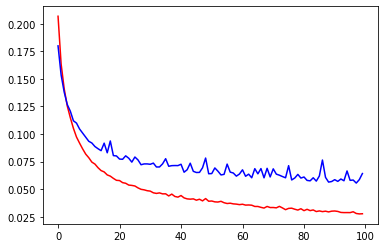

In [16]:
plt.plot(epoch_values, loss_values, c="red")
plt.plot(epoch_values, val_loss_values, c="blue")
plt.show()


#### Affichage de l'accuracy du modele

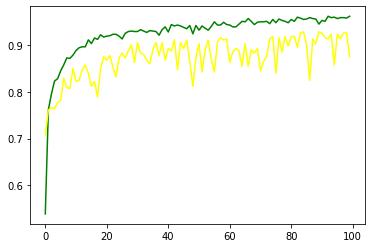

In [17]:
plt.plot(epoch_values, acc_values, c="green")
plt.plot(epoch_values, val_acc_values, c="yellow")
plt.show()

#### Prediction sur 3 nouvelles images

- Premiere image : **Un bas**
- Seconde image : **Une chaussure**
- Troisième image : **Un haut**

In [35]:
path_bas_one_image = os.getcwd() + "/../../Dataset/Raw/Bas/image_not_scrap/image_resize/b2.jpg"
test = load_one_image_dataset(path_bas_one_image)
print(model.predict(np.array([test[0]])))

path_chaussure_one_image = os.getcwd() + "/../../Dataset/Raw/Chaussure/image_not_scrap/image_resize/c1.jpg"
test = load_one_image_dataset(path_chaussure_one_image)
print(model.predict(np.array([test[0]])))

path_haut_one_image = os.getcwd() + "/../../Dataset/Raw/Haut/image_not_scrap/image_resize/h2.jpg"
test = load_one_image_dataset(path_haut_one_image)
print(model.predict(np.array([test[0]])))


C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Raw/Bas/image_not_scrap/image_resize/b2.jpg
[[0.993916   0.00473595 0.02109646]]
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Raw/Chaussure/image_not_scrap/image_resize/c1.jpg
[[0.14846268 0.808985   0.03601972]]
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Raw/Haut/image_not_scrap/image_resize/h2.jpg
[[0.39235023 0.00329523 0.8550007 ]]


### Tenserbord

In [53]:
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [54]:
%tensorboard --logdir logs

Reusing TensorBoard on port 6006 (pid 16672), started 14:20:16 ago. (Use '!kill 16672' to kill it.)

## Conclusion Tenserflow VS nos modeles
Nous pouvons alors constater que via keras le model predit bien les bonne classe pour chaque image.

Mais nous pouvons aussi constaté, comme dans nos propre model d'entrainement, que le model a plus de mal à predire la classe Haut.

### Hypothèse concernant l'accuracy faible

Nous pouvons alors faire une hypothèse concernant nos entraînements sur notre dataset via notre lib ou tenserflow/keras.
Dans les deux cas l'entraînement sur le dataset de validation nous renvoie une accuracy assez faible, aux alentours de 80 %

Nous avons émis alors l'hypothèse que cela est dû à notre dataset. Nous avons remarqué que notre modele a du mal à différencier la classe bas et haut, mais particulièrement les shorts de couleur blanc. Pour notre modèle d'entraînement, certaines voire tous nos images de short de couleur blanc sont considérer comme des hauts. Cela implique alors une erreur dans notre dataset ce qui peut alors provoquer ce biais dans notre entraînement. 

In [50]:
path_bas_one_image = os.getcwd() + "/../../Dataset/Train/Bas/b (1).jpg"
test = load_one_image_dataset(path_bas_one_image)
print(model.predict(np.array([test[0]])))

path_bas_one_image = os.getcwd() + "/../../Dataset/Train/Bas/b (61).jpg"
test = load_one_image_dataset(path_bas_one_image)
print(model.predict(np.array([test[0]])))

path_bas_one_image = os.getcwd() + "/../../Dataset/Train/Bas/b (121).jpg"
test = load_one_image_dataset(path_bas_one_image)
print(model.predict(np.array([test[0]])))

path_bas_one_image = os.getcwd() + "/../../Dataset/Train/Bas/b (59).jpg"
test = load_one_image_dataset(path_bas_one_image)
print(model.predict(np.array([test[0]])))

C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (1).jpg
[[0.1298588  0.33520165 0.5590902 ]]
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (61).jpg
[[0.02525512 0.6447139  0.76389736]]
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (121).jpg
[[0.22649257 0.07244527 0.70873016]]
C:\Users\MOI\dev\PA-MachineLearning-3ESGI\Project\Docs\Rapport/../../Dataset/Train/Bas/b (59).jpg
[[0.2472058  0.17722297 0.54563975]]


Comme nous pouvons constater pour chaque image que nous avons testé, le modèle nous renvoie que les bas font partie de la classe haut. Nous pouvons alors émette l'hypothèse que due aux nombres élevés de haut de couleur blanche dans le dataset d'entraînement et des shorts de couleurs blanche dans le dataset d'entraînement pourrais avoir une incidence sur l'entraînement de nos modèles

Pour terminer, si nous devions comparer nos entraînements avec notre lib et celle de tenserflow, nous pouvons constater avec les résultats obtenus que nos prédictions sur le dataset obtiennent des résultats similaires à ceux de Tenserflow/kerras. L'avantage de notre librairie est que là lib est légère et facile d'utilisation. L'entraînement est plutôt rapide pour des petits datasets ce qui convient plutôt bien pour nos pratiques. En revanche, les entraînements avec keras propose bien plus de paramétrage concernant l'entraînement, de choisir comme on le souhaite la fonction d'activation de notre choix ... Les entraînements restent quand même bien plus efficace sur un gros dataset